In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 

from matplotlib import font_manager as fm 
from matplotlib import cm 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from scipy.sparse import hstack

dataset = pd.read_csv("review_train.csv")



dataset.head()

#EDA 1: THE LENGTH OF THE SENTENCE

dataset['length_title']=dataset['REVIEW_TITLE'].str.split(" ").str.len()

dataset['length_text']=dataset['REVIEW_TEXT'].str.split(" ").str.len()

length0_title = dataset[dataset['LABEL']==0]['length_title']
length0_text = dataset[dataset['LABEL']==0]['length_text']
length1_title = dataset[dataset['LABEL']==1]['length_title']
length1_text = dataset[dataset['LABEL']==1]['length_text']

#give 0 to missing data

plt.hist([length0_title,length1_title], label=[0,1])
plt.legend()
plt.show()

plt.hist([length0_text,length1_text], label=[0,1],range=(0,100))
plt.legend()
plt.show()


/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/apple/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

In [2]:
dataset['Cap_title'] = dataset['REVIEW_TITLE'].str.count(r'[A-Z]')/dataset['REVIEW_TITLE'].str.len()

dataset['Cap_text'] = dataset['REVIEW_TEXT'].str.count(r'[A-Z]')/dataset['REVIEW_TEXT'].str.len()

dataset.head()

,REVIEW_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,length_title,length_text,Cap_title,Cap_text
0,17023,0,5.0,Y,Baby,B00EZM7A34,"Bumkins Nixi Ciclo Silicone Teething Necklace,...",Great idea for Mom's with teething babies,Great idea for Mom's with teething babies. The...,7.0,21.0,0.048780,0.046296
1,3260,1,4.0,N,Home Entertainment,B000MXB33S,Toshiba SD-V295 Tunerless DVD VCR Combo Player,Great purchase for the price,We needed a new VCR and found this one with th...,5.0,47.0,0.035714,0.042857
2,3834,1,4.0,N,Musical Instruments,B00BR1IX8W,pBone PBONE2B Jiggs Mini Plastic Trombone for ...,the best trombone,my so love trombone and so i purchased this on...,3.0,53.0,0.000000,0.000000
3,3284,1,4.0,N,Home Entertainment,B001DZFYPW,Toshiba SD-V296 Tunerless DVD VCR Combo Player...,Works well,"I picked up one of these recently, does what i...",2.0,32.0,0.100000,0.069444
4,15519,0,5.0,Y,Watches,B0088BN3LG,Bulova Men's 98B169 CAMPTON Two-Tone Bracelet ...,Excellent article!,"Very elegant and sophisticated watch, I love t...",2.0,21.0,0.055556,0.022727


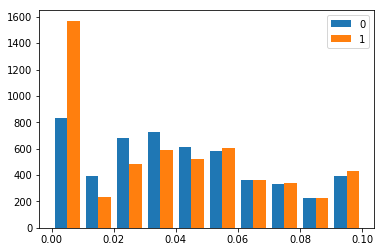

In [3]:
plt.hist([dataset[dataset['LABEL']==0]['Cap_title'],dataset[dataset['LABEL']==1]['Cap_title']],label=[0,1],range=(0,0.1))
plt.legend()
plt.show()

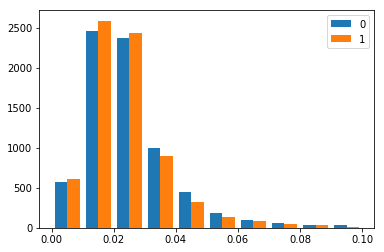

In [4]:
plt.hist([dataset[dataset['LABEL']==0]['Cap_text'],dataset[dataset['LABEL']==1]['Cap_text']],label=[0,1],range=(0,0.1))
plt.legend()
plt.show()

In [5]:
dataset_bench=dataset[["length_title","length_text","Cap_title","Cap_text"]]
dataset_bench=dataset_bench.fillna(dataset_bench.mean())

In [6]:
dataset_bench.isnull().sum()

length_title    0
length_text     0
Cap_title       0
Cap_text        0
dtype: int64

In [7]:
bench_matrix=dataset_bench.as_matrix()

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [8]:
dataset_number = dataset[["RATING","VERIFIED_PURCHASE"]]
dataset_number= dataset_number.replace({"N": 0, "Y": 1})
dataset_number = dataset_number.fillna(0)
number_matrix=dataset_number.as_matrix()

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [9]:
df = pd.read_csv("review_train.csv")
df_droped = df.drop(columns=['REVIEW_ID', 'PRODUCT_ID','PRODUCT_CATEGORY','VERIFIED_PURCHASE','RATING','LABEL'])
df_droped = df_droped.applymap(str)
#这里要把所有的都变为string，不然没有办法转为tfidf值
df_droped

,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,"Bumkins Nixi Ciclo Silicone Teething Necklace,...",Great idea for Mom's with teething babies,Great idea for Mom's with teething babies. The...
1,Toshiba SD-V295 Tunerless DVD VCR Combo Player,Great purchase for the price,We needed a new VCR and found this one with th...
2,pBone PBONE2B Jiggs Mini Plastic Trombone for ...,the best trombone,my so love trombone and so i purchased this on...
3,Toshiba SD-V296 Tunerless DVD VCR Combo Player...,Works well,"I picked up one of these recently, does what i..."
4,Bulova Men's 98B169 CAMPTON Two-Tone Bracelet ...,Excellent article!,"Very elegant and sophisticated watch, I love t..."
5,DenadaDance Tailor’s Bunion Pads Set of 3 - So...,I was a little skeptical when I opened the pac...,I was a little skeptical when I opened the pac...
6,Bixle 1/2-Inch Extra Thick 15 mm 72-Inch Long ...,"Hello sit-ups, it's been a while!",I am a somewhat overweight male. I got this be...
7,"Master Airbrush Brand 1/4"" BSP Male to 1/8"" BS...",Works exactly as advertised,I purchased this for use on a TC compressor an...
8,PYRUS Magnet Wireless Headphones Bluetooth V4....,Nice set of headphones. Best buy. You won't re...,"Took a little longer to arrive, but there's no..."
9,**MOST HEALTHY** Car Air Purifier Ionizer with...,highly recommend!!,I have to say that this is the best car air pu...


In [10]:

TfidfV = TfidfVectorizer(stop_words = 'english',max_features=2000,min_df=2,max_df=0.97)
#初始化模型，可以在里面设置参数
# df是document frequency，就是有多少个句子包含这个单词。
TfidfV.fit(df_droped['REVIEW_TITLE'])
TfidfV.fit(df_droped['REVIEW_TEXT'])
TfidfV.fit(df_droped['PRODUCT_TITLE'])

#训练模型


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.97, max_features=2000, min_df=2,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [11]:
X_train_tfidf_TITLE = TfidfV.transform(df_droped['REVIEW_TITLE'])
X_train_tfidf_TEXT = TfidfV.transform(df_droped['REVIEW_TEXT'])
X_train_tfidf_PROTITLE = TfidfV.transform(df_droped['PRODUCT_TITLE'])
X_train_tfidf_PROTITLE

<14700x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 100779 stored elements in Compressed Sparse Row format>

In [12]:

#PCA
#X_train_array_TITLE = X_train_tfidf_TITLE.toarray()


In [13]:
combine = hstack((X_train_tfidf_TITLE,X_train_tfidf_TEXT,X_train_tfidf_PROTITLE))
combine

<14700x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 279264 stored elements in COOrdinate format>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(combine,dataset['LABEL'],test_size=0.2,random_state=0)


X_train_array_new = X_train.toarray()



In [15]:





#pca = PCA(n_components=3)
#设定降维后的维度为3
#after_pca = pca.fit_transform(X_train_array_new)
#after_pca

In [16]:
#plt.figure(figsize=(10,10))
#plt.scatter(after_pca[:, 0], after_pca[:, 1], s=20, c=y_train,cmap='rainbow')
#plt.show()

In [17]:
clf = LogisticRegression()
#初始化逻辑回归模型
clf.fit(X_train, y_train)
#训练模型  这里用来训练的x可以是稀疏矩阵，array和dataframe

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
#fig = plt.figure(figsize=(10,10))
#ax = Axes3D(fig)
#ax.scatter(after_pca[:, 0], after_pca[:, 1],after_pca[:, 2],s=25, c=y_train,cmap='rainbow')

In [19]:
y_pred = clf.predict(X_test)
# 得到预测值
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.65      0.66      0.66      1459
           1       0.66      0.65      0.66      1481

   micro avg       0.66      0.66      0.66      2940
   macro avg       0.66      0.66      0.66      2940
weighted avg       0.66      0.66      0.66      2940



In [20]:
combine_new_1=hstack((combine,bench_matrix))

X_train, X_test, y_train, y_test = train_test_split(combine_new_1,dataset['LABEL'],test_size=0.2,random_state=0)


clf = LogisticRegression()
#初始化逻辑回归模型
clf.fit(X_train, y_train)
#训练模型  这里用来训练的x可以是稀疏矩阵，array和dataframe

y_pred = clf.predict(X_test)
# 得到预测值
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.66      0.65      0.65      1459
           1       0.66      0.67      0.66      1481

   micro avg       0.66      0.66      0.66      2940
   macro avg       0.66      0.66      0.66      2940
weighted avg       0.66      0.66      0.66      2940



In [21]:
combine_new_2=hstack((combine_new_1,number_matrix))

X_train, X_test, y_train, y_test = train_test_split(combine_new_2,dataset['LABEL'],test_size=0.2,random_state=0)


clf = LogisticRegression()
#初始化逻辑回归模型
clf.fit(X_train, y_train)
#训练模型  这里用来训练的x可以是稀疏矩阵，array和dataframe

y_pred = clf.predict(X_test)
# 得到预测值
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1459
           1       0.84      0.81      0.83      1481

   micro avg       0.83      0.83      0.83      2940
   macro avg       0.83      0.83      0.83      2940
weighted avg       0.83      0.83      0.83      2940



In [22]:
combine_new_2


<14700x6006 sparse matrix of type '<class 'numpy.float64'>'
	with 358143 stored elements in COOrdinate format>

In [23]:
parameter_space = {
    "penalty":['l1', 'l2'],
    "fit_intercept":[True,False]
}

In [24]:
clf = LogisticRegression()
grid_lr = GridSearchCV(clf, parameter_space, cv=5)
grid_lr.fit(X_train,y_train)

/Users/apple/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l1', 'l2'], 'fit_intercept': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
y_pred = grid_lr.predict(X_test)
# 得到预测值
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1459
           1       0.84      0.81      0.83      1481

   micro avg       0.83      0.83      0.83      2940
   macro avg       0.83      0.83      0.83      2940
weighted avg       0.83      0.83      0.83      2940



In [26]:
#test
dataset_test = pd.read_csv("review_test.csv")

#calculate the length and capital letter ratio
dataset_test['length_title']=dataset_test['REVIEW_TITLE'].str.split(" ").str.len()
dataset_test['length_text']=dataset_test['REVIEW_TEXT'].str.split(" ").str.len()
dataset_test['Cap_title'] = dataset_test['REVIEW_TITLE'].str.count(r'[A-Z]')/dataset_test['REVIEW_TITLE'].str.len()
dataset_test['Cap_text'] = dataset_test['REVIEW_TEXT'].str.count(r'[A-Z]')/dataset_test['REVIEW_TEXT'].str.len()

# transfer verified purchase to 0,1
dataset_test_number = dataset_test[["RATING","VERIFIED_PURCHASE"]]
dataset_test_number= dataset_test_number.replace({"N": 0, "Y": 1})
dataset_test_number = dataset_test_number.fillna(0)
test_number_matrix=dataset_test_number.as_matrix()

#fill the missing length and raito to mean
dataset_test['Cap_title']=dataset_test['Cap_title'].fillna(dataset_test['Cap_title'].mean())
dataset_test['Cap_text']=dataset_test['Cap_text'].fillna(dataset_test['Cap_text'].mean())
dataset_test['length_title']=dataset_test['length_title'].fillna(dataset_test['length_title'].mean())
dataset_test['length_text']=dataset_test['length_text'].fillna(dataset_test['length_text'].mean())


#deal with the text data
test_text_data = dataset_test.drop(columns=['REVIEW_ID', 'PRODUCT_ID','PRODUCT_CATEGORY','VERIFIED_PURCHASE','RATING'])
test_text_data = test_text_data.applymap(str)

TfidfV.fit(test_text_data['REVIEW_TITLE'])
TfidfV.fit(test_text_data['REVIEW_TEXT'])
TfidfV.fit(test_text_data['PRODUCT_TITLE'])

X_test_tfidf_TITLE = TfidfV.transform(test_text_data['REVIEW_TITLE'])
X_test_tfidf_TEXT = TfidfV.transform(test_text_data['REVIEW_TEXT'])
X_test_tfidf_PROTITLE = TfidfV.transform(test_text_data['PRODUCT_TITLE'])


test_numerical=dataset_test[["length_title","length_text","Cap_title","Cap_text"]]
test_numerical_matrix=test_numerical.as_matrix()

data_input=hstack((X_test_tfidf_TITLE,X_test_tfidf_TEXT,X_test_tfidf_PROTITLE,test_number_matrix,test_numerical_matrix))

review_id = dataset_test[['REVIEW_ID']]
pre_label = grid_lr.predict(data_input)
review_id["pred_label"] = pre_label

review_id.to_csv('Group39_BUSS6002_Assignment2_Test_Results.csv',index=False)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
pre_label

array([1, 0, 0, ..., 1, 0, 1])